In [3]:
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
from shapely.geometry import Point, Polygon
import numpy as np
import pickle

In [4]:
states_gdf = gpd.read_file('shapeFile/cb_2018_us_nation_5m.shp')
states_gdf

,AFFGEOID,GEOID,NAME,geometry
0,0100000US,US,United States,"MULTIPOLYGON (((179.48246 51.98283, 179.48656 ..."


Mainland at polygon 146 


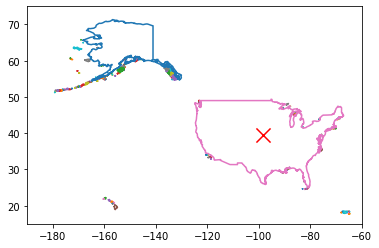

In [3]:
usaCenter = Point(-98.35,39.50)
for idx,i in enumerate(states_gdf['geometry'][0]):
    x,y = i.exterior.xy
    plt.plot(x,y)
    if usaCenter.within(i):
        usaPoly = np.array([(yi,xi) for xi,yi in zip(x,y)])
        print("Mainland at polygon {} ".format(idx))
plt.scatter([-98.35], [39.50], c='r', marker='x', s=200)
plt.xlim([-190,-60])
plt.ylim([15,75])
plt.show()

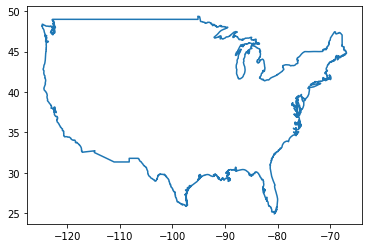

array([[  48.169997, -124.731746],
       [  48.184422, -124.704153],
       [  48.198599, -124.696111],
       ...,
       [  48.160402, -124.731703],
       [  48.163393, -124.733174],
       [  48.169997, -124.731746]])

In [4]:
plt.plot(usaPoly[:,1],usaPoly[:,0])
plt.show()
usaPoly

In [5]:
pickle.dump(usaPoly,open("usaPoly.pkl","wb"))

# Polygo split

In [1]:
import shapely
import gmaps
from shapely.geometry import Point, Polygon, box
from matplotlib import pyplot as plt
import numpy as np
import pickle

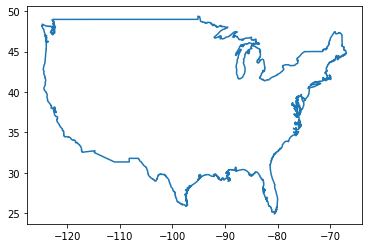

In [2]:
usaPoly = pickle.load(open("usaPoly.pkl",'rb'))
usaPoly = Polygon(np.flip(usaPoly))
x,y = usaPoly.exterior.xy
plt.plot(x,y)

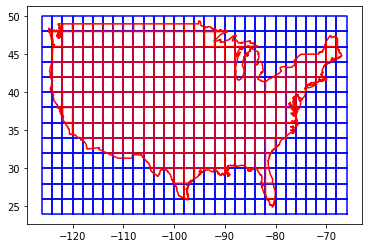

In [3]:
dim = 2
bounds = usaPoly.bounds
xmin = int(bounds[0] // dim)
xmax = int(bounds[2] // dim)
ymin = int(bounds[1] // dim)
ymax = int(bounds[3] // dim)
for i in range(xmin, xmax+1):
    for j in range(ymin, ymax+1):
        b = box(i*dim, j*dim, (i+1)*dim, (j+1)*dim)
        g = usaPoly.intersection(b)
        x,y = b.exterior.xy
        plt.plot(x,y,c='b')
        if g.is_empty:
            continue
        if type(g)==shapely.geometry.multipolygon.MultiPolygon:
            for gems in g.geoms:
                x,y = gems.exterior.xy
                plt.plot(x,y,c='r')
        else:
            x,y = g.exterior.xy
            plt.plot(x,y,c='r')
plt.show()

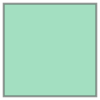

In [6]:
b

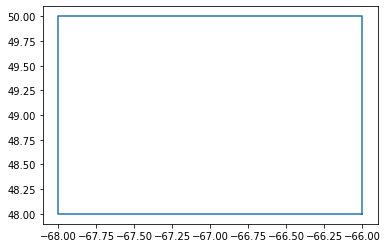

In [10]:
x,y =  b.exterior.xy
plt.plot(x,y)

In [8]:
b.bounds

(-68.0, 48.0, -66.0, 50.0)

In [4]:
def partition(polygon, dim, mergeFactor=0.1):
    bounds = polygon.bounds
    xmin = int(bounds[0] // dim)
    xmax = int(bounds[2] // dim)
    ymin = int(bounds[1] // dim)
    ymax = int(bounds[3] // dim)
    grid = 0
    res = []
    for i in range(xmin, xmax+1):
        for j in range(ymin, ymax+1):
            b = box(i*dim, j*dim, (i+1)*dim, (j+1)*dim)
            g = polygon.intersection(b)
            if g.is_empty:
                continue
            if type(g)==shapely.geometry.multipolygon.MultiPolygon:
                for gems in g.geoms:
                    res.append(gems)
                    grid += 1
            else:
                res.append(g)
                grid += 1
    return merge(res, mergeFactor)

def merge(polyList, mergeFactor=0.1):
    def combine(pidx, polyL):
        p = polyL[pidx]
        del polyL[pidx]
        for idx,i in enumerate(polyL):
            u = p.union(i)
            if p.intersects(i) and type(u)!=shapely.geometry.multipolygon.MultiPolygon:
                polyL[idx] = u
                break
        return polyL
    
    mnLimit = max(polyList, key=lambda x:x.area).area * mergeFactor
    mnPoly = min(polyList, key=lambda x:x.area)
    while(mnPoly.area<=mnLimit):
        polyList = combine(polyList.index(mnPoly), polyList)
        mnPoly = min(polyList, key=lambda x:x.area)
        
    result = {}
    for idx,i in enumerate(polyList):
        x,y = i.exterior.xy
        result[idx] = np.array([(y,x) for x,y in zip(x,y)])
    return result

def plotMap(polyGrid):
    gPoly = []
    gMarkLoc = []
    gMarkInf = []
    info_box_template = """
    <dl>
    <dd>{}</dd>
    </dl>
    """
    for k,v in polyGrid.items():
        gPoly.append(gmaps.Polygon(
                        list(v),
                        stroke_color='red',
                        fill_color='blue'
                        ))
        gMarkLoc.append((v[0][0],v[0][1]))
        gMarkInf.append(info_box_template.format(k))
    fig = gmaps.figure(center=(39.50,-98.35), zoom_level=4, map_type='TERRAIN')
    fig.add_layer(gmaps.drawing_layer(features=gPoly))
#     fig.add_layer(gmaps.marker_layer(gMarkLoc, info_box_content=gMarkInf))
    return fig

In [5]:
usaPolyGrid = partition(usaPoly, 2, mergeFactor=0.1)

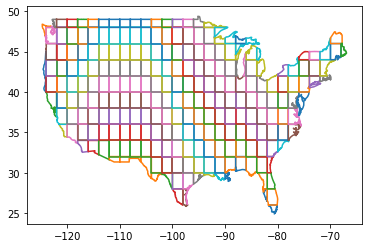

243

In [6]:
for i in usaPolyGrid.values():
    plt.plot(i[:,1],i[:,0])
plt.show()
len(usaPolyGrid)

In [7]:
plotMap(usaPolyGrid)

Figure(layout=FigureLayout(height='420px'))

In [8]:
pickle.dump(usaPolyGrid,open("usaPolyGrid.pkl","wb"))

In [ ]:
usaPolyGrid = pickle.load(open("usaPolyGrid.pkl",'rb'))